# Compare RNN map & Transformer LFMCS to true observations

**Purpose:** We want to compare metrics by the RNN maps to predictions by the transformer model.

**Date:** July 29, 2024


### Setup

In [1]:
from hydroDL import kPath

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import json
from sklearn.metrics import r2_score

loading package hydroDL


In [2]:
# Data split by site, stored as time series in .csv files 

# in-situ data paths
our_obs_dir = f'{kPath.dirVeg}predictions/true_obs2_interpolate_semimonthly/' 
krishna_obs_dir = f"{kPath.dirVeg}predictions/true_obs_krishna/"

# predictions paths
transformer_dir = f'{kPath.dirVeg}predictions/transformer_interpolate_semimonthly/' 
rnn_maps_andy_dir = f'{kPath.dirVeg}predictions/rnn_semimonthly_andy/' # andy and kuai both independently downloaded data 
rnn_maps_kuai_dir = f'{kPath.dirVeg}predictions/rnn_semimonthly_kuai/' # andy and kuai both independently downloaded data 


In [3]:
def shift_date(date):
    if date.day == 15:
        return date.replace(day=1)
    elif date.day in [30, 31, 28]:
        # Find the last day of the month
        return date.replace(day=15)

### Test performance

In [95]:
# get sites
sites_path = os.path.join(kPath.dirVeg, 'predictions/non_train_siteIds_both_models_all.csv')
# sites_path = os.path.join(kPath.dirVeg, 'predictions/non_train_siteIds_both_models_quality.csv')
# sites_path = os.path.join(kPath.dirVeg, 'predictions/non_train_siteIds_both_models_poor.csv')
sites = pd.read_csv(sites_path).siteId.unique()
len(sites)

161

In [56]:
# collate data
bad_sites = []
compare_df = pd.DataFrame({})

for site_id in sites:
    try:
        # Load site .csv files for true observation, rnn maps, transformer
        site_obs_path = f'{true_obs_dir}{site_id}.csv'
        site_rnn_path = f'{rnn_maps_dir}{site_id}.csv'
        site_rnn_kuai_path = f'{rnn_maps_kuai_dir}{site_id}.csv'
        site_transformer_path = f'{transformer_dir}{site_id}.csv'
        
        site_obs_df = pd.read_csv(site_obs_path, index_col=0)
        site_rnn_df = pd.read_csv(site_rnn_path, index_col=0)
        site_rnn_kuai_df = pd.read_csv(site_rnn_kuai_path, index_col=0)
        site_transformer_df = pd.read_csv(site_transformer_path, index_col=0)

        site_compare_df = pd.merge(site_obs_df, site_rnn_df, left_index=True, right_index=True) 
        site_compare_df['true_lfmc'] = site_compare_df['lfmc_x']
        site_compare_df['rnn_lfmc_andy'] = site_compare_df['lfmc_y']
        site_compare_df = site_compare_df.drop(['lfmc_x', 'lfmc_y'], axis=1)

        site_compare_df = pd.merge(site_compare_df, site_rnn_kuai_df, left_index=True, right_index=True)
        site_compare_df['rnn_lfmc_kuai'] = site_compare_df['b1']
        site_compare_df = site_compare_df.drop(['b1'], axis=1)

        site_compare_df = pd.merge(site_compare_df, site_transformer_df, left_index=True, right_index=True)
        site_compare_df['transformer_lfmc'] = site_compare_df['lfmc']
        site_compare_df = site_compare_df.drop(['lfmc'], axis=1)
        
        site_compare_df = site_compare_df.dropna()
        site_compare_df = site_compare_df[site_compare_df.rnn_lfmc_andy != 0]
      
        site_compare_df["site"] = [site_id for _ in range(len(site_compare_df))] 
        compare_df = pd.concat([compare_df, site_compare_df])
    
    except:
        bad_sites.append(site_id)

len(bad_sites)

9

In [119]:
# get metrics
# rnn_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.rnn_lfmc.astype('float')) ** 2))
# rnn_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.rnn_lfmc.astype('float'))[0, 1]
# rnn_coef_det = r2_score(compare_df.true_lfmc, compare_df.rnn_lfmc.astype('float'))

rnn_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.rnn_lfmc_andy.astype('float')) ** 2))
rnn_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.rnn_lfmc_andy.astype('float'))[0, 1]
rnn_coef_det = r2_score(compare_df.true_lfmc, compare_df.rnn_lfmc_andy.astype('float'))

rnn_kuai_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.rnn_lfmc_kuai.astype('float')) ** 2))
rnn_kuai_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.rnn_lfmc_kuai.astype('float'))[0, 1]
rnn_kuai_coef_det = r2_score(compare_df.true_lfmc, compare_df.rnn_lfmc_kuai.astype('float'))

transformer_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.transformer_lfmc) ** 2))
transformer_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.transformer_lfmc)[0, 1]
transformer_coef_det = r2_score(compare_df.true_lfmc, compare_df.transformer_lfmc)

metric_names = ["rmse", "correlation coefficient", "coefficient of determination"]
rnn_metrics = [rnn_rmse, rnn_corr_coef, rnn_coef_det]
rnn_kuai_metrics = [rnn_kuai_rmse, rnn_kuai_corr_coef, rnn_kuai_coef_det]
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

metrics_dict = {
    "metrics" : metric_names,
    "rnn_andy" : rnn_metrics,
    "rnn_kuai" : rnn_kuai_metrics,
    "transformer" : transformer_metrics
}

metrics = pd.DataFrame(metrics_dict)
metrics

,metrics,rnn_andy,rnn_kuai,transformer
0,rmse,44.139749,44.233890,30.723735
1,correlation coefficient,0.262475,0.268337,0.617527
2,coefficient of determination,-0.352415,-0.358190,0.344763


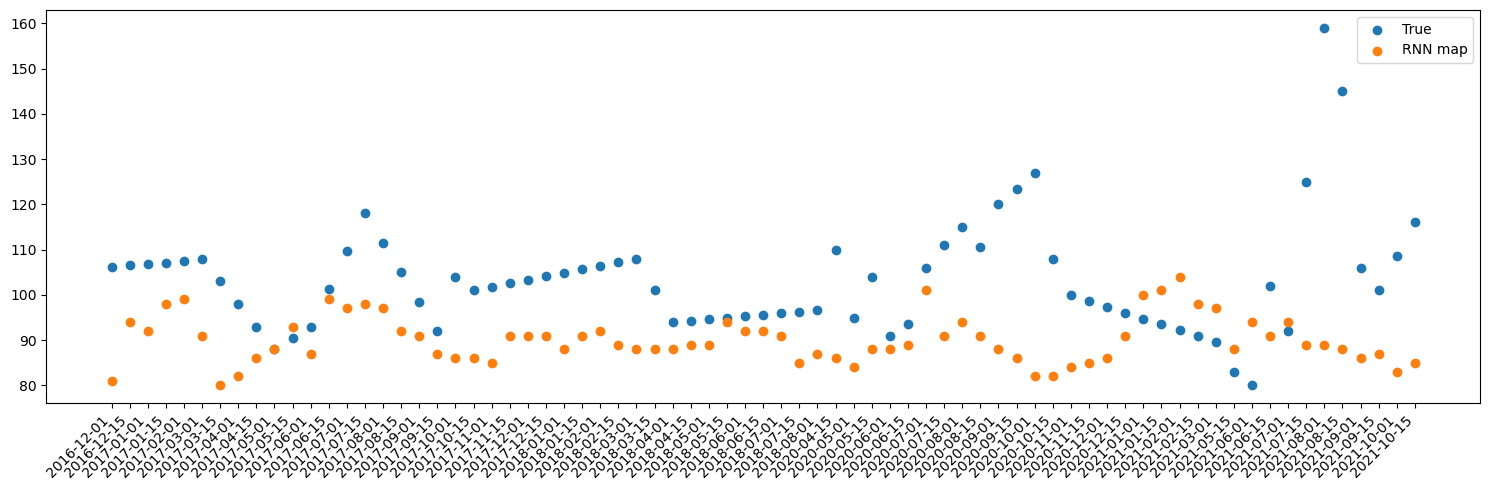

In [44]:
# get time series of given site
site_id = 4
sub_compare_df = compare_df[compare_df.site == sites[site_id]]

plt.figure(figsize=(15, 5))
plt.scatter(sub_compare_df.index, sub_compare_df.true_lfmc)
plt.scatter(sub_compare_df.index, sub_compare_df.rnn_lfmc)
# plt.scatter(sub_compare_df.index, sub_compare_df.transformer_lfmc)

plt.legend(["True", "RNN map", "Transformer"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

### Krishna 66 performance

In [191]:
# Get sites of interest (intersection betweeen Krishna's and our sites)

# load krishna's sites
rnn_df_path = '/Users/andyhuynh/Documents/lfmc/data/predictions/lstm_input_data_pure+all_same_28_may_2019_res_SM_gap_3M'
rnn_df = pd.read_pickle(rnn_df_path)

# load our sites
transformer_df_path = '/Users/andyhuynh/Documents/lfmc/data/model/data/singleDaily-nadgrid/site.csv'
transformer_df = pd.read_csv(transformer_df_path)

# get the intersection of sites
sites = transformer_df[transformer_df.siteName.isin(rnn_df.site.unique())].siteId.unique()

/var/folders/_6/xq5r06kd7qb_g5546y0zvvz80000gn/T/ipykernel_40394/3478686188.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axM.legend()


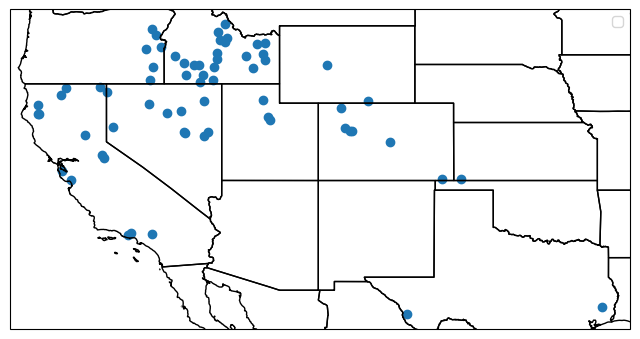

In [192]:
df = transformer_df[transformer_df.siteName.isin(rnn_df.site.unique())]

import cartopy.crs as ccrs
import cartopy.feature as cfeature

figM = plt.figure(figsize=(8, 6))
axM = figM.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

axM.scatter(df.lon, df.lat, transform=ccrs.PlateCarree())

axM.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

axM.legend()

plt.show()

In [5]:
# (1) Use both Andy's and Kuai's extractions to build dataframe to get performance metrics
# schema: [site, true_lfmc, rnn_lfmc_andy, rnn_lfmc_kuai] 

# Choose 1
# obs_dir = our_obs_dir
# obs_dir = krishna_obs_dir

compare_df = pd.DataFrame({})
bad_sites_andy = set()
bad_sites_kuai = set()

for site_id in sites:
    # load site .csv files for true observation, rnn maps, transformer
    site_obs_path = f'{obs_dir}{site_id}.csv'
    site_rnn_andy_path = f'{rnn_maps_andy_dir}{site_id}.csv'
    site_rnn_kuai_path = f'{rnn_maps_kuai_dir}{site_id}.csv'
        
    site_obs_df = pd.read_csv(site_obs_path, index_col=0)
    if obs_dir == krishna_obs_dir:
        
        site_obs_dfindex  = site_obs_df.index.map(shift_date)
    site_rnn_andy_df = pd.read_csv(site_rnn_andy_path, index_col=0)
    site_rnn_kuai_df = pd.read_csv(site_rnn_kuai_path, index_col=0)

    # Remove sites with no data
    # see 2 next comments
    if (site_rnn_andy_df.lfmc == 0).sum() == len(site_rnn_andy_df) and 'b1' not in site_rnn_kuai_df.columns:
        bad_sites_andy.add(site_id)
        bad_sites_kuai.add(site_id)
        continue

    # in andy's extraction, lfmc 0 means no data
    if (site_rnn_andy_df.lfmc == 0).sum() == len(site_rnn_andy_df): 
        bad_sites_andy.add(site_id)
        continue
    
    # in kuai's extraction, 'b1' is the name of lfmc column
    if 'b1' not in site_rnn_kuai_df.columns:
        bad_sites_kuai.add(site_id)
        continue

    site_compare_df = pd.merge(site_obs_df, site_rnn_andy_df, left_index=True, right_index=True)
    site_compare_df['true_lfmc'] = site_compare_df['lfmc_x']
    site_compare_df['rnn_lfmc_andy'] = site_compare_df['lfmc_y']
    site_compare_df = site_compare_df.drop(['lfmc_x', 'lfmc_y'], axis=1)
    
    site_compare_df = pd.merge(site_compare_df, site_rnn_kuai_df, left_index=True, right_index=True)
    site_compare_df['rnn_lfmc_kuai'] = site_compare_df['b1']
    site_compare_df = site_compare_df.drop(['b1'], axis=1)

    site_compare_df = site_compare_df.dropna()
    site_compare_df = site_compare_df[site_compare_df.rnn_lfmc_andy != 0]

    site_compare_df["site"] = [site_id for _ in range(len(site_compare_df))] 
    compare_df = pd.concat([compare_df, site_compare_df])

NameError: name 'obs_dir' is not defined

In [91]:
len(sites)

66

In [167]:
# (2) Use either Andy's or Kuai's extractions to build dataframe to get performance metrics
# schema: [site, true_lfmc, rnn_lfmc_andy, rnn_lfmc_kuai] 

# Choose 1
obs_dir = our_obs_dir
# obs_dir = krishna_obs_dir

compare_df = pd.DataFrame({})
bad_sites_andy = set()
bad_sites_kuai = set()
used_sites = []

for site_id in sites:
    # load site .csv files for true observation, rnn maps, transformer
    site_obs_path = f'{obs_dir}{site_id}.csv'
    site_rnn_andy_path = f'{rnn_maps_andy_dir}{site_id}.csv'
    site_rnn_kuai_path = f'{rnn_maps_kuai_dir}{site_id}.csv'
        
    site_obs_df = pd.read_csv(site_obs_path, index_col=0)
    site_rnn_andy_df = pd.read_csv(site_rnn_andy_path, index_col=0)
    site_rnn_kuai_df = pd.read_csv(site_rnn_kuai_path, index_col=0)

    if obs_dir == krishna_obs_dir:
        site_obs_df = site_obs_df.set_index(pd.DatetimeIndex(site_obs_df.index))
        site_obs_df.index = site_obs_df.index.map(shift_date)
        site_rnn_kuai_df = site_rnn_kuai_df.set_index(pd.DatetimeIndex(site_rnn_kuai_df.index))

    # Remove sites with no data
    # see 2 next comments
    # if (site_rnn_andy_df.lfmc == 0).sum() == len(site_rnn_andy_df) and 'b1' not in site_rnn_kuai_df.columns:
    #     bad_sites_andy.add(site_id)
    #     bad_sites_kuai.add(site_id)
    #     continue

    # # in andy's extraction, lfmc 0 means no data
    # if (site_rnn_andy_df.lfmc == 0).sum() == len(site_rnn_andy_df): 
    #     bad_sites_andy.add(site_id)
    #     continue
    
    # in kuai's extraction, 'b1' is the name of lfmc column
    if 'b1' not in site_rnn_kuai_df.columns:
        bad_sites_kuai.add(site_id)
        continue

    # CHOOSE 1
    # site_compare_df = pd.merge(site_obs_df, site_rnn_andy_df, left_index=True, right_index=True)
    # site_compare_df['true_lfmc'] = site_compare_df['lfmc_x']
    # site_compare_df['rnn_lfmc_andy'] = site_compare_df['lfmc_y']
    # site_compare_df = site_compare_df.drop(['lfmc_x', 'lfmc_y'], axis=1)
    # site_compare_df = site_compare_df[site_compare_df.rnn_lfmc_andy != 0]
    
    used_sites.append(site_id)
    site_compare_df = pd.merge(site_obs_df, site_rnn_kuai_df, left_index=True, right_index=True)
    site_compare_df['true_lfmc'] = site_compare_df['lfmc']
    site_compare_df['rnn_lfmc_kuai'] = site_compare_df['b1']
    site_compare_df = site_compare_df.drop(['b1'], axis=1)
    # site_compare_df = site_compare_df.dropna()

    site_compare_df["site"] = [site_id for _ in range(len(site_compare_df))] 
    compare_df = pd.concat([compare_df, site_compare_df])

In [168]:
len(bad_sites_kuai)

13

In [169]:
used_sites = set(used_sites)
final_sites = set(compare_df.site.unique())

In [170]:
len(used_sites)

53

In [171]:
len(final_sites)

53

In [172]:
# compare_df = compare_df[compare_df.index >= "2015-01-01"]
# compare_df = compare_df[compare_df.index < "2019-03-01"]
# compare_df = compare_df[compare_df.index >= "2019-03-01"]

In [175]:
compare_df_nona = compare_df.dropna()

# rnn_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.rnn_lfmc_andy.astype('float')) ** 2))
# rnn_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.rnn_lfmc_andy.astype('float'))[0, 1]
# rnn_coef_det = r2_score(compare_df.true_lfmc, compare_df.rnn_lfmc_andy.astype('float'))

rnn_kuai_rmse = np.sqrt(np.mean((compare_df_nona.true_lfmc - compare_df_nona.rnn_lfmc_kuai.astype('float')) ** 2))
rnn_kuai_corr_coef = np.corrcoef(compare_df_nona.true_lfmc, compare_df_nona.rnn_lfmc_kuai.astype('float'))[0, 1]
rnn_kuai_coef_det = r2_score(compare_df_nona.true_lfmc, compare_df_nona.rnn_lfmc_kuai.astype('float'))

# transformer_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.transformer_lfmc) ** 2))
# transformer_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.transformer_lfmc)[0, 1]
# transformer_coef_det = r2_score(compare_df.true_lfmc, compare_df.transformer_lfmc)

metric_names = ["rmse", "correlation coefficient", "coefficient of determination"]
# rnn_metrics = [rnn_rmse, rnn_corr_coef, rnn_coef_det]
rnn_kuai_metrics = [rnn_kuai_rmse, rnn_kuai_corr_coef, rnn_kuai_coef_det]
# transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

metrics_dict = {
    "metrics" : metric_names,
    # "rnn_andy" : rnn_metrics,
    "rnn_kuai" : rnn_kuai_metrics,
    # "transformer" : transformer_metrics
}

metrics = pd.DataFrame(metrics_dict)
metrics

,metrics,rnn_kuai
0,rmse,36.841149
1,correlation coefficient,0.633049
2,coefficient of determination,0.186001


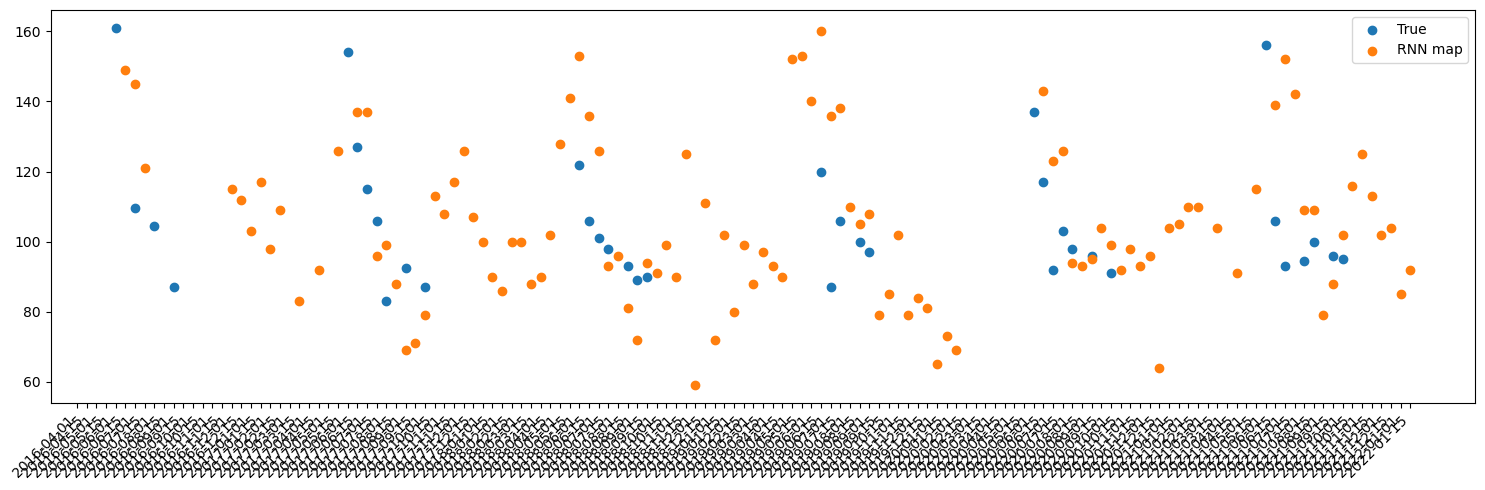

In [176]:
# get time series of given site
site_idx = 2
sub_compare_df = compare_df[compare_df.site == sites[site_idx]]

plt.figure(figsize=(15, 5))
plt.scatter(sub_compare_df.index, sub_compare_df.true_lfmc)
plt.scatter(sub_compare_df.index, sub_compare_df.rnn_lfmc_kuai)

plt.legend(["True", "RNN map"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [177]:
siteId_lst = []
# rnn_rmse_lst = []
# rnn_corr_coef_lst = []
# rnn_coef_det_lst = []
rnn_kuai_rmse_lst = []
rnn_kuai_corr_coef_lst = []
rnn_kuai_coef_det_lst = []

for siteId in compare_df.site.unique():
    site_compare_df = compare_df[compare_df.site == siteId]
    site_compare_df = site_compare_df.dropna()

    # rnn_rmse = np.sqrt(np.mean((site_compare_df.true_lfmc - site_compare_df.rnn_lfmc_andy.astype('float')) ** 2))
    # rnn_corr_coef = np.corrcoef(site_compare_df.true_lfmc, site_compare_df.rnn_lfmc_andy.astype('float'))[0, 1]
    # rnn_coef_det = r2_score(site_compare_df.true_lfmc, site_compare_df.rnn_lfmc_andy.astype('float'))

    rnn_kuai_rmse = np.sqrt(np.mean((site_compare_df.true_lfmc - site_compare_df.rnn_lfmc_kuai.astype('float')) ** 2))
    rnn_kuai_corr_coef = np.corrcoef(site_compare_df.true_lfmc, site_compare_df.rnn_lfmc_kuai.astype('float'))[0, 1]
    rnn_kuai_coef_det = r2_score(site_compare_df.true_lfmc, site_compare_df.rnn_lfmc_kuai.astype('float'))

    siteId_lst.append(siteId)
    # rnn_rmse_lst.append(rnn_rmse)
    # rnn_corr_coef_lst.append(rnn_corr_coef)
    # rnn_coef_det_lst.append(rnn_coef_det)
    rnn_kuai_rmse_lst.append(rnn_kuai_rmse)
    rnn_kuai_corr_coef_lst.append(rnn_kuai_corr_coef)
    rnn_kuai_coef_det_lst.append(rnn_kuai_coef_det)
    

In [178]:
data = {
    "siteId": siteId_lst,
    # "rmse_andy": rnn_rmse_lst,
    # "corr_coef_andy": rnn_corr_coef_lst,
    # "coef_det_andy": rnn_coef_det_lst,
    "rmse_kuai": rnn_kuai_rmse_lst,
    "corr_coef_kuai": rnn_kuai_corr_coef_lst,
    "coef_det_kuai": rnn_kuai_coef_det_lst,
}

site_metrics = pd.DataFrame(data)

In [179]:
metrics_top = []
metrics_bottom = []

sorted_metrics = site_metrics.sort_values("coef_det_kuai", ascending=False)
for i in range(1, len(sorted_metrics)):
    metrics_top.append(sorted_metrics[:-i]["coef_det_kuai"].mean())
    metrics_bottom.append(sorted_metrics[-i:]["coef_det_kuai"].mean())

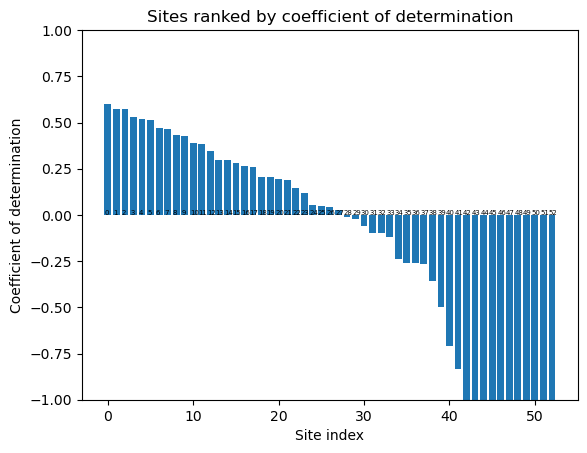

In [181]:
plt.bar(range(53), sorted_metrics.coef_det_kuai)
for i in range(53):
    plt.text(i-0.4,0,i, fontsize=5)
plt.ylim(-1, 1)
plt.title("Sites ranked by coefficient of determination")
plt.xlabel("Site index")
plt.ylabel("Coefficient of determination")
plt.show()

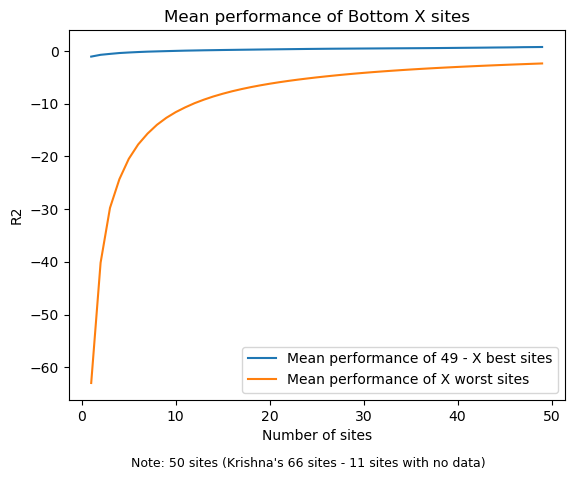

In [355]:
plt.plot(range(1, 50), metrics_top)
plt.plot(range(1, 50), metrics_bottom)
plt.title("Mean performance of Bottom X sites")
plt.legend(["Mean performance of 49 - X best sites", "Mean performance of X worst sites"])
plt.xlabel("Number of sites")
plt.ylabel("R2")

txt="Note: 50 sites (Krishna's 66 sites - 11 sites with no data)"
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=9)

plt.show()

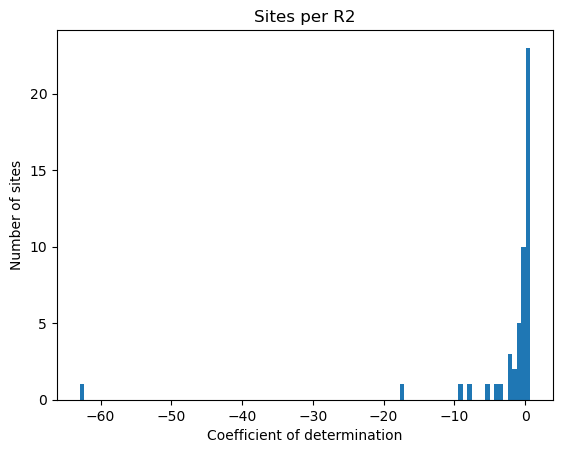

In [356]:
plt.hist(site_metrics.coef_det_kuai, bins=100)
plt.title("Sites per R2")
plt.xlabel("Coefficient of determination")
plt.ylabel("Number of sites")
plt.show()

In [249]:
(site_metrics.corr_coef_kuai < 0.1).sum()

9

### Transformer daily stats + random experiments

In [259]:
path = os.path.join(kPath.dirVeg, "predictions/transformer_lfmc_daily.csv")
transformer_daily_df = pd.read_csv(path)

path = os.path.join(kPath.dirVeg, "NFMD/NFMD.csv")
true_daily_df = pd.read_csv(path)

In [260]:
daily_df = pd.merge(transformer_daily_df, true_daily_df, left_on=["site", "date"], right_on=["siteId", "Date"])

transformer_rmse = np.sqrt(np.mean((daily_df.lfmc - daily_df.Percent) ** 2))
transformer_corr_coef = np.corrcoef(daily_df.lfmc, daily_df.Percent)[0, 1]
transformer_coef_det = r2_score(daily_df.lfmc, daily_df.Percent)
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

daily_metrics_dict = {
    "metrics" : metric_names,
    "transformer" : transformer_metrics
}

daily_metrics = pd.DataFrame(daily_metrics_dict)
daily_metrics

,metrics,transformer
0,rmse,22.687895
1,correlation coefficient,0.844393
2,coefficient of determination,0.599314


In [261]:
# get quality and poor sites
path = os.path.join(kPath.dirVeg, "model/data/singleDaily-nadgrid/site.csv")
site_df = pd.read_csv(path)

splits_path = os.path.join(kPath.dirVeg, 'model', 'attention', 'dataset')
splits_json = os.path.join(splits_path, 'subset.json')

with open(splits_json) as json_file:
    splits = json.load(json_file)

quality_test_sites = splits['testSite_k05']
poor_test_sites = splits['testSite_underThresh']

quality_sites = site_df.iloc[quality_test_sites].siteId.tolist()
poor_sites = site_df.iloc[poor_test_sites].siteId.tolist()


In [262]:
sub_daily_df = daily_df[daily_df.site.isin(quality_sites)]

transformer_rmse = np.sqrt(np.mean((sub_daily_df.lfmc - sub_daily_df.Percent) ** 2))
transformer_corr_coef = np.corrcoef(sub_daily_df.lfmc, sub_daily_df.Percent)[0, 1]
transformer_coef_det = r2_score(sub_daily_df.lfmc, sub_daily_df.Percent)
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

daily_metrics_dict = {
    "metrics" : metric_names,
    "transformer" : transformer_metrics
}

daily_metrics = pd.DataFrame(daily_metrics_dict)
daily_metrics

,metrics,transformer
0,rmse,17.414221
1,correlation coefficient,0.912409
2,coefficient of determination,0.798819


In [263]:
sub_daily_df = daily_df[daily_df.site.isin(poor_sites)]

transformer_rmse = np.sqrt(np.mean((sub_daily_df.lfmc - sub_daily_df.Percent) ** 2))
transformer_corr_coef = np.corrcoef(sub_daily_df.lfmc, sub_daily_df.Percent)[0, 1]
transformer_coef_det = r2_score(sub_daily_df.lfmc, sub_daily_df.Percent)
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

daily_metrics_dict = {
    "metrics" : metric_names,
    "transformer" : transformer_metrics
}

daily_metrics = pd.DataFrame(daily_metrics_dict)
daily_metrics

,metrics,transformer
0,rmse,26.099252
1,correlation coefficient,0.784638
2,coefficient of determination,0.380525


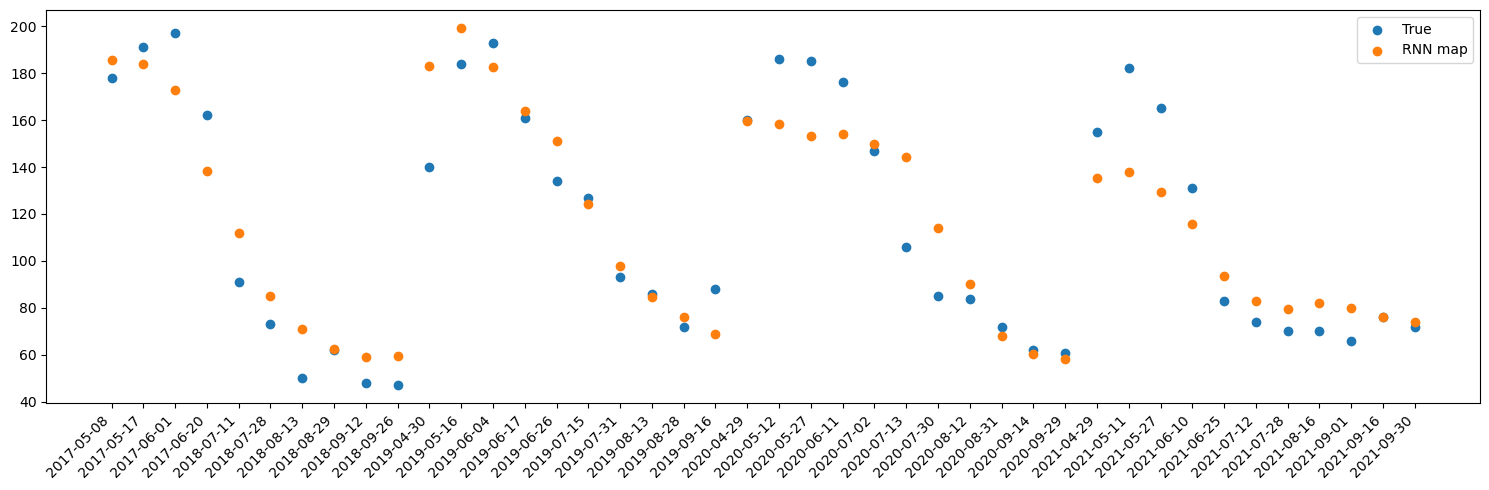

In [268]:
# get time series of given site
site_idx = 10
sub_daily_df = daily_df[daily_df.site == quality_sites[site_idx]]

plt.figure(figsize=(15, 5))
plt.scatter(sub_daily_df.Date, sub_daily_df.Percent)
plt.scatter(sub_daily_df.Date, sub_daily_df.lfmc)

plt.legend(["True", "RNN map", "Transformer"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [106]:
compare_df["rnn_diff"] = abs(compare_df.true_lfmc - compare_df.rnn_lfmc)
compare_df["transformer_diff"] = abs(compare_df.true_lfmc - compare_df.transformer_lfmc)

In [107]:
diff_by_site = compare_df.groupby("site").mean()

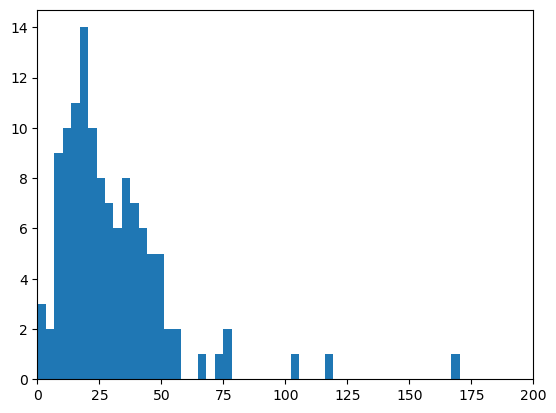

In [108]:
plt.hist(diff_by_site.rnn_diff, bins=50)
plt.xlim(0, 200)
plt.show()

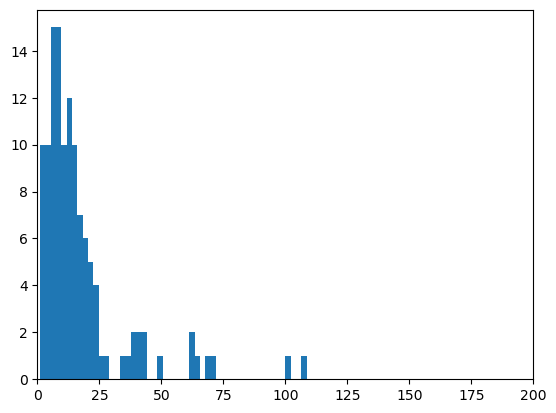

In [109]:
plt.hist(diff_by_site.transformer_diff, bins=50)
plt.xlim(0, 200)
plt.show()

### Compare andy RNN extraction wth Kuai RNN extraction

In [68]:
andy_bad_sites = []
kuai_bad_sites = []
both_bad_sites = []

site_id_lst = []
andy_lst = []
kuai_lst = []


for site_id in sites:
    site_andy_rnn_path = f'{rnn_maps_dir}{site_id}.csv'
    site_andy_rnn_df = pd.read_csv(site_andy_rnn_path, index_col=0)
    site_andy_rnn_df = site_andy_rnn_df[site_andy_rnn_df.index >= "2015-01-01"]
    site_andy_rnn_df = site_andy_rnn_df[site_andy_rnn_df.index < "2019-03-01"]

    site_kuai_rnn_path = f'{rnn_maps_kuai_dir}{site_id}.csv'
    site_kuai_rnn_df = pd.read_csv(site_kuai_rnn_path, index_col=0)
    site_kuai_rnn_df = site_kuai_rnn_df[site_kuai_rnn_df.index >= "2015-01-01"]
    site_kuai_rnn_df = site_kuai_rnn_df[site_kuai_rnn_df.index < "2019-03-01"]

    if (site_andy_rnn_df.lfmc == 0).sum() == len(site_andy_rnn_df) and 'b1' not in site_kuai_rnn_df.columns:
        both_bad_sites.append(site_id)
        continue
    
    if (site_andy_rnn_df.lfmc == 0).sum() == len(site_andy_rnn_df):
        andy_bad_sites.append(site_id)
        continue
    
    if 'b1' not in site_kuai_rnn_df.columns:
        kuai_bad_sites.append(site_id)
        continue
    
    andy_lst.append((site_andy_rnn_df.lfmc == 0).sum())
    kuai_lst.append(site_kuai_rnn_df['b1'].isna().sum())
    site_id_lst.append(site_id)

In [69]:
len(andy_bad_sites)

3

In [70]:
len(kuai_bad_sites)

2

In [71]:
len(both_bad_sites)

11

In [79]:
data = {
    "site" : site_id_lst,
    "andy" : andy_lst,
    "kuai" : kuai_lst
}
df = pd.DataFrame(data)
df['diff'] = abs(df.andy - df.kuai)
len(df)

50

In [83]:
df['andy'].mean()


24.56

In [84]:
df['kuai'].mean()

25.72

In [6]:
compare_df["diff"] = compare_df.andy - compare_df.kuai
compare_diff_df = compare_df.groupby("site").agg("mean")["diff"]

In [7]:
site_info = pd.read_csv(os.path.join(kPath.dirVeg, "model/data/singleDaily-modisgrid-new-const/site.csv"))
compare_diff_df = pd.merge(compare_diff_df, site_info, left_on="site", right_on="siteId")

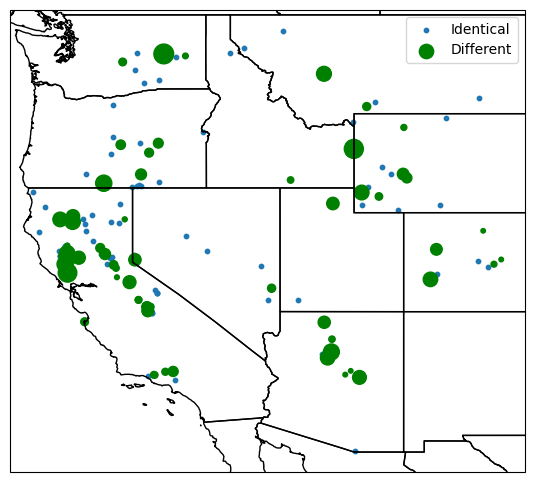

In [51]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


figM = plt.figure(figsize=(8, 6))
axM = figM.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot each set with different colors on the map
axM.scatter(compare_diff_df.lon[compare_diff_df["diff"] == 0], compare_diff_df.lat[compare_diff_df["diff"] == 0], label='Identical', s=10, transform=ccrs.PlateCarree())
axM.scatter(compare_diff_df.lon[compare_diff_df["diff"] != 0], compare_diff_df.lat[compare_diff_df["diff"] != 0], c="green", label='Different', s=abs(compare_diff_df[compare_diff_df["diff"] != 0]["diff"]) * 10 + 10, transform=ccrs.PlateCarree())

axM.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

axM.legend()
plt.show()